In [1]:
import sys
sys.path.insert(0, 'visualization.py')
sys.path.insert(0, 'utils.py')

In [2]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-11-16 16:08:48,599 - utils - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [3]:
n_frame = 0
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(10, 8)


# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [4]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

(51, 8)


# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

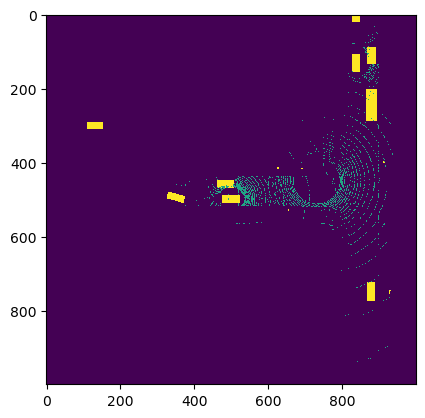

In [5]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  ------------------  
box_mask = box_to_pixels(irsu_boxes[:,:7], bev_imsize, bev_resolution)
bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
    bev_occupancy[pixel[1], pixel[0]] = 150


plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class

In [6]:
# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)

# Define a color map for class labels
CLASS_COLORS = {
    0.0: [255, 0, 0],    # Red for class 0 - Cars?
    1.0: [0, 255, 0],    # Green for class 1 - Maybe its a truck?
    2.0: [0, 0, 255],    # Blue for class 2 - Cyclist?
    3.0: [255, 255, 0],  # Yellow for class 3 - Traffic lights?
    #Need to confirm in the dataset, what each label corresponds to
    
}


def filter_detections_by_class(boxes, class_labels, desired_classes):
    '''
    boxes: (N_boxes, 8) : eight corners of the box and the class label as the last value in each row
    class_labels: List of class labels (integers or floats)
    desired_classes: Set of classes to keep (e.g., {0, 1} for vehicles and pedestrians)

    return: filtered boxes and their corresponding class labels
    '''
    # Mask to filter boxes based on the desired classes
    mask = np.isin(class_labels, list(desired_classes))
    
    # Filter boxes and class labels
    filtered_boxes = boxes[mask]
    filtered_classes = class_labels[mask]
    
    return filtered_boxes, filtered_classes

def get_class_colors(class_labels):
    '''
    Given a list of class labels, return the corresponding colors.
    '''
    colors = []
    for label in class_labels:
        # Ensure label is an integer
        label = int(label)
        colors.append(CLASS_COLORS.get(label, [0, 0, 0]))  # Default to black if class is unknown
    return np.array(colors)



In [7]:
desired_classes = {0.0, 1.0, 2.0, 3.0}  # Replace with desired classes you want to visualize
irsu_boxes_filtered, filtered_classes = filter_detections_by_class(
    irsu_boxes[:, :7],  # Assuming the last column is the class label
    irsu_boxes[:, -1],  # Class labels are in the last column of `irsu_boxes`
    desired_classes
)

# Get colors for the filtered detections
box_colors = get_class_colors(filtered_classes)

# Visualize or use `irsu_boxes_filtered` for further processing
show_objects(filtered_points, irsu_boxes_filtered, box_colors)

